<a href="https://colab.research.google.com/github/nicoeiris11/seeds-classification/blob/main/Seeds_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if can access data from the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls /content/drive/'My Drive'/Tryolabs-CV-Interview/data

sample_submission.csv  test/  train/


# Imports

In [ ]:
from google.colab import files
import os
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## GPU Usage

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data loading & analysis

This first part of the notebook have the following purposes:
- Load train folder
- Implement a reusable method to get DataLoaders splitted by train and validation.
- Analyze train data
  - Size of train folder
  - Randomly get a set of images and display them (with associated target)
  - Extract observations from images
  - Count images for each target class

Before working on the modeling, it is very important to really understand the data we are working with. If we do not analyze data and pre-process it correctly, final accuracy will likely be lower than it could be.

### Load images

In [ ]:
# Load images from train folder
transf = transforms.Compose([
    transforms.ToTensor()
])
train_dataset_path = "/content/drive/My Drive/Tryolabs-CV-Interview/data/train"
train_dataset = ImageFolder(train_dataset_path, transform=transf)
print(f"Full train dataset size: {len(train_dataset)}")

Full train dataset size: 4750


In [ ]:
# Count images for each target class
TARGET_CLASSES = train_dataset.classes

print("Count images for each target class in train dataset: \n")
for target_class in TARGET_CLASSES:
    class_count = len(os.listdir(os.path.join(train_dataset_path, target_class)))
    print(f"{target_class}: {class_count} images")

Count images for each target class in train dataset: 

Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


The quantity of images per target class is pretty well balanced. A good strategy when dataset is very unbalanced is to generate images for that specific classes with low amount of data.

In the following 2 cells I will create a DataLoader with 32 random examples (minibatch example).
The purpose of this is to randomly select some examples and print the size of the images to have an idea of the images dimension.

In [ ]:
BATCH_SIZE = 32

In [ ]:
# This function splits batch items into 2 lists [[image], [target]]
def collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

example_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True)
examples = enumerate(example_loader)

batch_idx, (example_data, example_targets) = next(examples)

for i in range(BATCH_SIZE):
  print(f"Image dimensions {example_data[i].shape}")

Image dimensions torch.Size([3, 622, 622])
Image dimensions torch.Size([3, 253, 253])
Image dimensions torch.Size([3, 316, 316])
Image dimensions torch.Size([3, 117, 117])
Image dimensions torch.Size([3, 376, 376])
Image dimensions torch.Size([3, 349, 349])
Image dimensions torch.Size([3, 172, 172])
Image dimensions torch.Size([3, 372, 372])
Image dimensions torch.Size([3, 602, 602])
Image dimensions torch.Size([3, 104, 104])
Image dimensions torch.Size([3, 380, 380])
Image dimensions torch.Size([3, 137, 137])
Image dimensions torch.Size([3, 88, 88])
Image dimensions torch.Size([3, 108, 108])
Image dimensions torch.Size([3, 166, 166])
Image dimensions torch.Size([3, 190, 190])
Image dimensions torch.Size([3, 533, 533])
Image dimensions torch.Size([3, 335, 335])
Image dimensions torch.Size([3, 151, 151])
Image dimensions torch.Size([3, 504, 504])
Image dimensions torch.Size([3, 133, 133])
Image dimensions torch.Size([3, 120, 120])
Image dimensions torch.Size([3, 289, 289])
Image dimensi

As we can see, dimension of the images vary a lot inside training set. 
I will resize all images to 256x256 dimension to quickly build a classifier and then continue iterating with more exhaustive data pre-processing & image augmentation taking results into account. I think 256x256 is a good dimension number not only because it's around average for all the images, but also to halve images inside nets multiple times without loosing information (power of 2).

I think starting with a simple solution and then continue iterating over and over is a good approach for this type of problems.

### Images visualization (mini-batch)

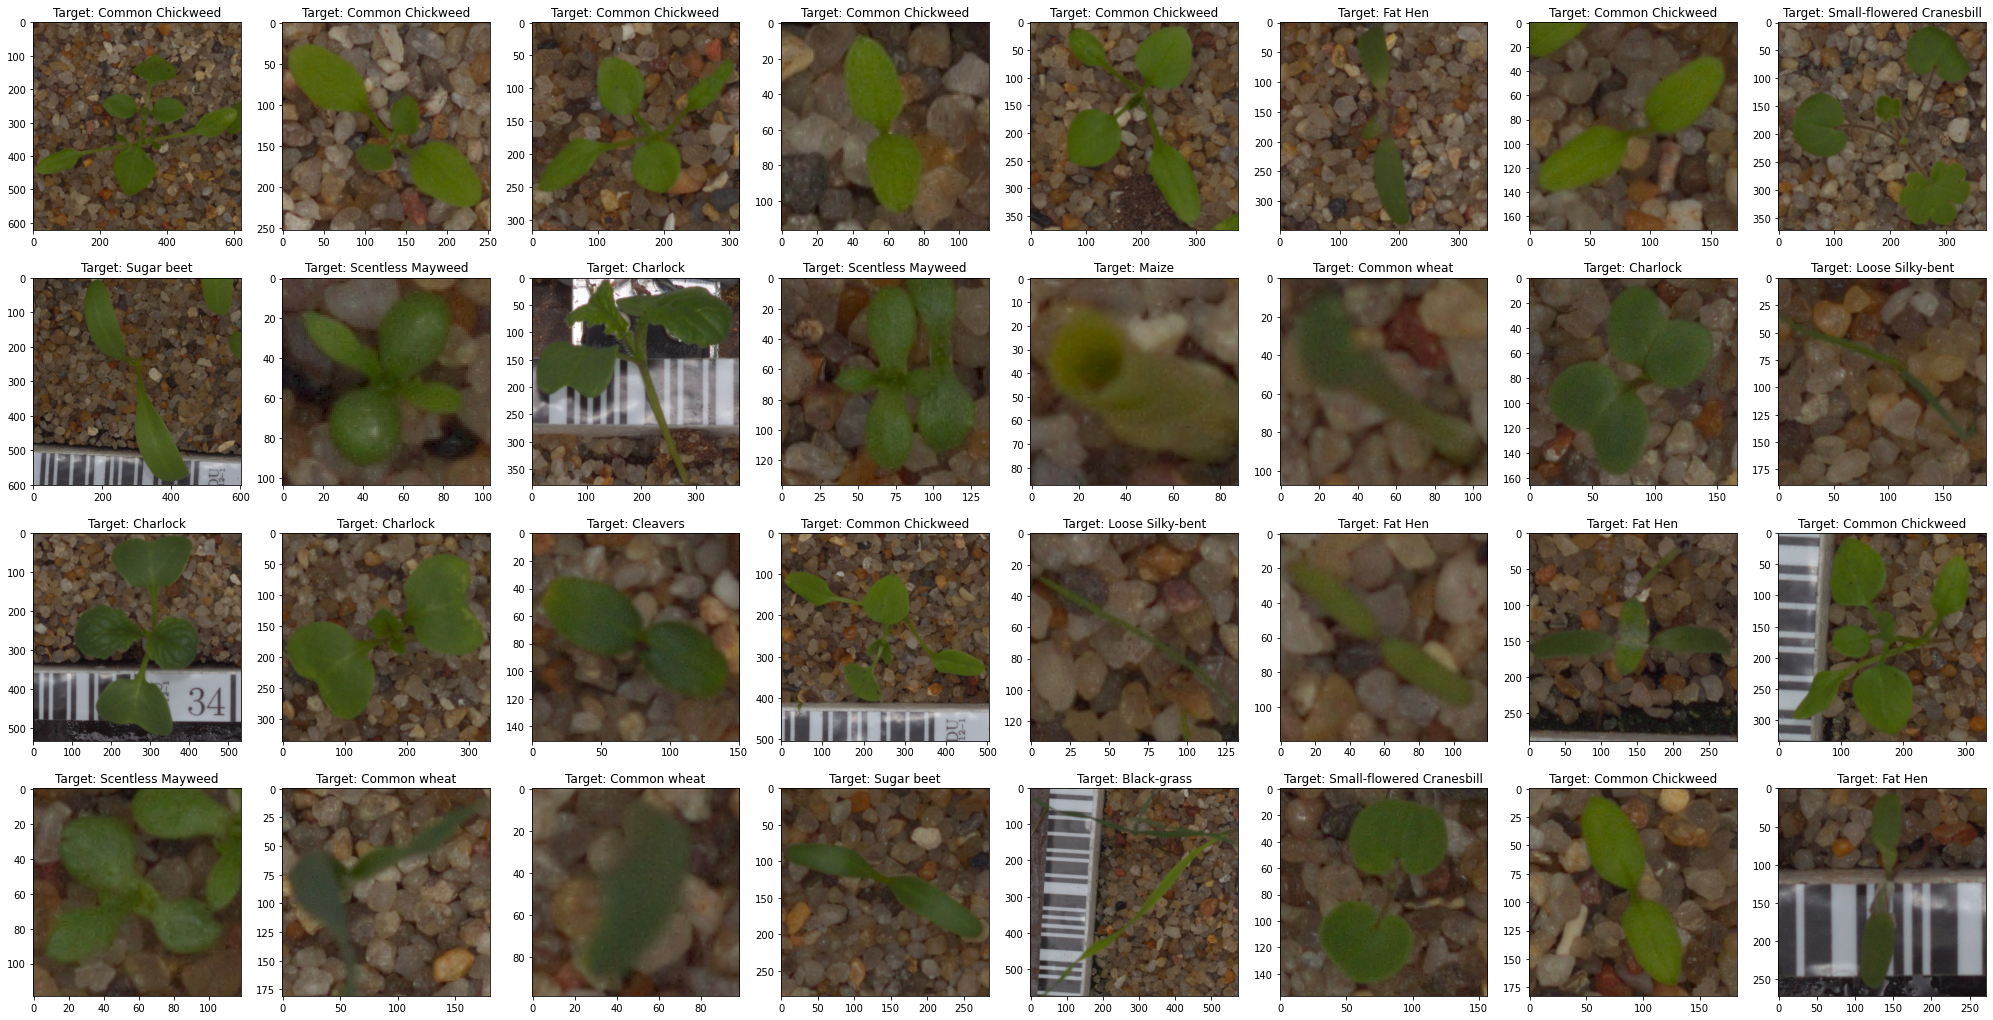

In [ ]:
fig = plt.figure(figsize=(35, 18))
for i in range(BATCH_SIZE):
  image = example_data[i]
  image = image.numpy().transpose((1, 2, 0))
  image = np.clip(image, 0, 1)
  plt.subplot(4, 8, i+1)
  plt.imshow(image)
  plt.title(f"Target: {TARGET_CLASSES[example_targets[i]]}")
  

Observations:

 - Many images are blurry. 
 - The only green element in the images belong to the plant.
 - The intensity of green varies depending on the type of seed.
 - The background consists mostly of small rocks.
 - In some cases apart from small rocks there is a bar code next to the plant.

## Image Augmentation

Taking images observations into account, I will present Image Augmentation strategy to train the classifier. This technique will be used to favor generalization of the model (reduce overfitting by applying regularization technique). Basically I will apply certain transformations to the images while training in order to learn features from images with different color, brightness, rotations, etc.

Considering the images for this problem I will use the following transformations:

*   RandomHorizontalFlip & RandomVerticalFlip - With a probability of 50% flip the image horizontally & vertically. As the photos where taken from above the plants, is reasonable to flip them both horizontally or vertically. There are some cases where this does not apply, for example if we are classifying landscapes images, is reasonable to flip horizontally but not vertically, since is not real to have the sky and the sun bellow the mountains and trees.
*   ColorJitter - As many images are blurry and poor lighting, I will randomly apply changes to color, saturation and brightness of the image.
*   RandomErasing - This transform removes a small rectangle of the image. Randomly erasing sections of the image improves generalization by avoiding to remember specific images characteristics.

## DataLoader generator

The following function creates a dataloader for train & validation.
Instead of repeating code along the notebook I prefer defining a generic and reusable method to abstract the responsability of building a DataLoader.

**Input**: train_transforms, batch_size

**Output**: train_DataLoader, validation_DataLoader

I will use 20% of train dataset for validation.

In [ ]:
def get_dataloaders(train_transf, batch_size):
  train_dataset = ImageFolder("/content/drive/My Drive/Tryolabs-CV-Interview/data/train", transform=train_transf)

  # Split train & validation
  train_size = int(0.8 * len(train_dataset))
  valid_size = len(train_dataset) - train_size
  train, validation = random_split(train_dataset, [train_size, valid_size])
  print(f"{len(train)} Training images, {len(validation)} Validation images")

  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
  valid_loader = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

  return train_loader, valid_loader

# Train and validate methods

Before moving to the model implementation, I will define train and validate methods.

Train method will be responsible of iterating through epochs in order to run the model for predictions, calculate the loss and run backprop to update model (net) weights.

Validate method will be used for validation set. For this one the model will be switched to validation state just to predict and calculate the loss (no backprop present in this phase).





## How will I measure model performance?

It is very important to define metrics to track model performance along the time. The main metric I will use to track performance will be **F1 Score** since is the metric used by Kaggle competition to evaluate predictions. In addition I will also present other metrics such as: **Accuracy**, **Precission** & **Recall**

In [ ]:
# Input:
#        - training_model: neural net to train.
#        - loader: DataLoader with training data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - average loss of the epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
#
# Apart from metrics, for each training epoch I will track cumulative loss in order to plot loss evolution
def train_epoch(training_model, loader, criterion, optim):
    # set model to train state
    training_model.train()
    
    epoch_loss = 0.0
    
    # save 'y' and 'y_hat' for each image prediction
    all_labels = []
    all_predictions = []

    for images, labels in loader:
        # add mini-batch targets (tensor to list) to the end of 'all_labels' list
        all_labels.extend(labels.numpy())

        # reset gradients
        optim.zero_grad()

        # predict and save result to 'all_predictions' list
        # mini-batch images are mounted to the GPU
        predictions = training_model(images.to(device))

        # using cpu to get the class with highest value returned by the net
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        # mount labels to GPU and calculate loss comparing them with model predictions
        loss = criterion(predictions, labels.to(device))
        loss.backward()

        # Backprop, compute gradients and update model parameters
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [ ]:
# Input:
#        - val_model: neural net to validate.
#        - loader: DataLoader with validation data.
#        - criterion: loss function.
# Output:
#        - average loss of the validation epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
def validation_epoch(val_model, loader, criterion):
    # set model to test state
    val_model.eval()
  
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad(): # temporarily set all the requires_grad flag to false
      for images, labels in loader:
          all_labels.extend(labels.numpy())
    
          predictions = val_model(images.to(device))
          all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
    
          loss = criterion(predictions, labels.to(device))
    
          epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [ ]:
# Input:
#        - model: neural net to train.
#        - train_loader: DataLoader with train data.
#        - validation_loader: DataLoader with validation data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - train_history: list with the average loss of each training epoch
#        - validation_history: list with the average loss of each validation epoch
def train_model(model, train_loader, validation_loader, criterion, optim, number_epochs):
  train_history = []
  validation_history = []

  for epoch in range(number_epochs):
      # track time for each epoch
      start_time = time.time()

      # Training epoch
      train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, train_f1, train_prec, train_recall, time.time() - start_time))

      # Validation epoch
      start_time = time.time()
      valid_loss, valid_acc, valid_prec, valid_recall, valid_f1 = validation_epoch(model, validation_loader, criterion)
      validation_history.append(valid_loss)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, valid_loss, valid_acc, valid_f1, valid_prec, valid_recall, time.time() - start_time))

  return train_history, validation_history

# Model definition & training

In the following section I will present 3 deep neural networks. How does a neural network learn image features? This a good question and generally this architectures learn more complex features of the image while moving forward in the layers.

So, the first layers of the net learn simple features such as horizontal lines, vertical lines, circles and generalized shapes. Going deeper in the network, the model learns more complex things directly associated with the problem itself. At this point the model will learn to detect the leaves, the rocks in the background and even the bar codes.

## 1) Custom CNN

As a first attempt, I will implement a cutom Convolutional Neural Network and see how it peforms.


In [ ]:
class CustomCNN(nn.Module):
  def __init__(self, in_channels):
    # in_channels: int, quantity of original image channels
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(num_features = 32)
 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(num_features = 64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(num_features = 128)

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride = 1, padding = 1)
    self.bn4 = nn.BatchNorm2d(num_features = 256)

    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride = 1, padding = 1)
    self.bn5 = nn.BatchNorm2d(num_features = 512)

    self.conv6 = nn.Conv2d(in_channels=512, out_channels=890, kernel_size=3, stride = 1, padding = 1)
    self.bn6 = nn.BatchNorm2d(num_features = 890)

    self.conv7 = nn.Conv2d(in_channels=890, out_channels=1024, kernel_size=3, stride = 1, padding = 1)
    self.bn7 = nn.BatchNorm2d(num_features = 1024)

    self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.dropout = nn.Dropout(0.5)
    
    self.linear1 = nn.Linear(in_features=1024 * 2 * 2, out_features=2048)
    self.linear2 = nn.Linear(in_features=2048, out_features=976)
    self.linear3 = nn.Linear(in_features=976, out_features=212)
    self.output = nn.Linear(in_features = 212, out_features=len(TARGET_CLASSES))

  def forward(self, x):
    result = F.relu(self.bn1(self.conv1(x)))
    result = self.pooling(result)

    result = F.relu(self.bn2(self.conv2(result)))
    result = self.pooling(result)
    
    result = F.relu(self.bn3(self.conv3(result)))
    result = self.pooling(result)

    result = F.relu(self.bn4(self.conv4(result)))
    result = self.pooling(result)
    
    result = F.relu(self.bn5(self.conv5(result)))
    result = self.pooling(result)

    result = F.relu(self.bn6(self.conv6(result)))
    result = self.pooling(result)

    result = F.relu(self.bn7(self.conv7(result)))
    result = self.pooling(result)
    
    # transforms tensor to vector for Fully Connected input
    result = result.flatten(1)
    
    result = self.dropout(result)
    result = F.relu(self.linear1(result))

    result = self.dropout(result)
    result = F.relu(self.linear2(result))

    result = self.dropout(result)
    result = F.relu(self.linear3(result))

    result = self.output(result)
    return result

#### Without Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

custom_cnn_net = CustomCNN(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(custom_cnn_net.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(custom_cnn_net, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images
Training epoch 1 | Loss 1.986461 | Accuracy 32.03% | F1 25.49% | Precision 29.26% | Recall 32.03% | Time 104.85 seconds
Validation epoch 1 | Loss 1.423705 | Accuracy 46.95% | F1 42.81% | Precision 44.54% | Recall 46.95% | Time 51.59 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.274196 | Accuracy 55.61% | F1 52.60% | Precision 52.45% | Recall 55.61% | Time 46.94 seconds
Validation epoch 2 | Loss 0.883035 | Accuracy 70.53% | F1 68.68% | Precision 71.41% | Recall 70.53% | Time 11.93 seconds
Training epoch 3 | Loss 0.920972 | Accuracy 68.61% | F1 67.43% | Precision 67.42% | Recall 68.61% | Time 46.72 seconds
Validation epoch 3 | Loss 0.772226 | Accuracy 72.84% | F1 72.22% | Precision 75.57% | Recall 72.84% | Time 12.14 seconds
Training epoch 4 | Loss 0.681019 | Accuracy 77.00% | F1 76.07% | Precision 76.20% | Recall 77.00% | Time 48.07 seconds
Validation epoch 4 | Loss 0.547212 | Accuracy 80.63% | F1 80.30% | Precision 81.89% | Recall 80.63% | Time 12.41 seconds
Training epoch 5 | Loss 0.532952 | Accuracy 81.76% | F1 81.22% | Precision 81.24% | Recall 81.76% | Time 48.88 seconds
Validation epoch 5 | Loss 0.663143 | Accuracy 76.53% | F1 75.63% | Precision 78.60% | Recall 76.53% | Time 12.42 seconds
Training epoch 6 | Loss 0.431121 | Accur

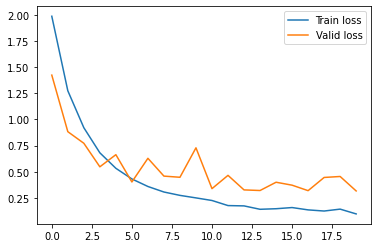

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

#### With Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

custom_cnn_net_with_aug = CustomCNN(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(custom_cnn_net_with_aug.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(custom_cnn_net_with_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images
Training epoch 1 | Loss 2.086673 | Accuracy 28.50% | F1 21.88% | Precision 23.73% | Recall 28.50% | Time 49.69 seconds
Validation epoch 1 | Loss 1.652408 | Accuracy 40.53% | F1 33.07% | Precision 37.13% | Recall 40.53% | Time 12.61 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.415649 | Accuracy 51.71% | F1 48.10% | Precision 48.12% | Recall 51.71% | Time 50.02 seconds
Validation epoch 2 | Loss 1.230390 | Accuracy 58.53% | F1 54.87% | Precision 58.46% | Recall 58.53% | Time 12.71 seconds
Training epoch 3 | Loss 1.129007 | Accuracy 61.87% | F1 60.17% | Precision 60.23% | Recall 61.87% | Time 48.98 seconds
Validation epoch 3 | Loss 1.064214 | Accuracy 62.53% | F1 59.70% | Precision 64.73% | Recall 62.53% | Time 12.56 seconds
Training epoch 4 | Loss 0.925037 | Accuracy 68.55% | F1 66.95% | Precision 67.17% | Recall 68.55% | Time 49.58 seconds
Validation epoch 4 | Loss 0.872086 | Accuracy 69.47% | F1 68.19% | Precision 70.98% | Recall 69.47% | Time 12.68 seconds
Training epoch 5 | Loss 0.821340 | Accuracy 70.89% | F1 69.73% | Precision 69.62% | Recall 70.89% | Time 49.31 seconds
Validation epoch 5 | Loss 0.796372 | Accuracy 73.26% | F1 72.72% | Precision 76.53% | Recall 73.26% | Time 12.62 seconds
Training epoch 6 | Loss 0.697150 | Accur

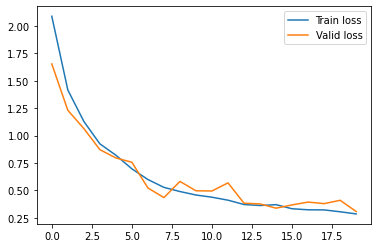

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

## 2) ResNet 18

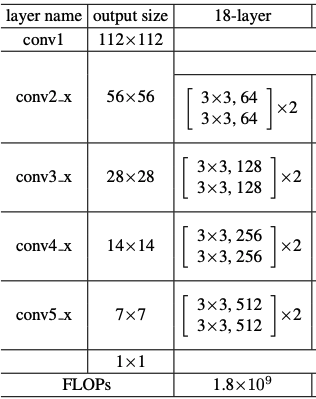

In the following section you can find **ResNet-18** implementation based on "Deep Residual Learning for Image Recognition" [paper](https://arxiv.org/pdf/1512.03385.pdf). I decided to implement ResNet because other architectures such as Lenet, AlexNet and VGGNet may suffer *vanishing gradients* phenomenon and prefer trying directly with a deeper solution that prevents this issue.

This is the main reason why this architecture appeared. Older solutions are deeper enough to learn complex features, but as they get deeper, backpropagation makes the first layers weights to be near 0. This happens because it derives from the end to the beginning making gradients smaller while going backwards.

The main idea of ResNet is to add a residual connection between non consecutive layers. Given *layer_n* this mechanism enables backpropagation to update not only *layer_n-1* but also *layer_n-2* weights.

The following image illustrates ResNet-34 (which is very similar to ResNet-18) in order to make implementation explanation easier.


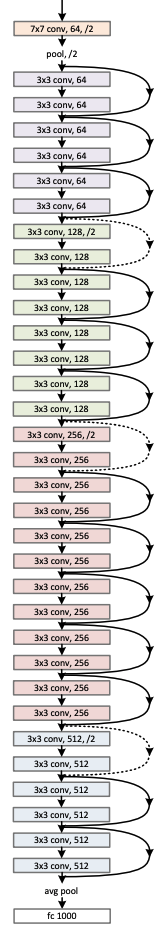



In [ ]:
class ResNet18(nn.Module):
  def __init__(self, in_channels):
    super(ResNet18, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 7, padding = 3)
    
    self.group1 = ResGroup(channels = 64, should_halve = False)
    
    self.group2 = ResGroup(channels = 128, should_halve = True)
    
    self.group3 = ResGroup(channels = 256, should_halve = True)
    
    self.group4 = ResGroup(channels = 512, should_halve = True)

    self.bn = nn.BatchNorm2d(num_features = 64)
    self.max_pool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(0.5)
    
    self.linear1 = nn.Linear(in_features = 512 * 1 * 1, out_features = 128)
    self.output = nn.Linear(in_features = 128, out_features = 12)

  def forward(self, x):
    # orange conv in the image
    out = F.relu(self.bn(self.conv1(x)))
    
    out = self.max_pool(out)

    # violet group in the image, shouldHave=False because max_pool already downsampled vector 
    out = self.group1(out)

    # green group in the image, shouldHave=True because reduces prev group output dimension
    out = self.group2(out)

    # red group in the image
    out = self.group3(out)

    # blue group in the image, shouldHave=True because reduces prev group output dimension
    out = self.group4(out)

    out = self.avgpool(out)

    # tensor to vector as linear layer input
    out = out.flatten(1)

    out = self.dropout(out)

    # fc white block in the image
    out = F.relu(self.linear1(out))

    return self.output(out)

In [ ]:
# As we can see in the table above, every group has 2 blocks.
class ResGroup(nn.Module):
  def __init__(self, channels, should_halve):
    super(ResGroup, self).__init__()
    self.resBlock1 = ResBlock(channels, should_halve)
    self.resBlock2 = ResBlock(channels, False)
  
  def forward(self, x):
    out = self.resBlock1(x)
    out = self.resBlock2(out)
    return out

In [ ]:
# Residual block implementation
class ResBlock(nn.Module):
  def __init__(self, channels, should_halve):
    super(ResBlock, self).__init__()
    
    # if it is the first block of a group (not first group) need to reduce filters dimension
    self.should_halve = should_halve
    if should_halve:    
      self.conv1 = nn.Conv2d(in_channels = int(channels / 2), out_channels = channels, kernel_size = 3, stride = 2, padding = 1)
    else:
      self.conv1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
    
    self.conv2 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(num_features = channels)
    self.bn2 = nn.BatchNorm2d(num_features = channels)
    self.bn3 = nn.BatchNorm2d(num_features = channels)

    if should_halve:
      self.conv1x1 = nn.Conv2d(in_channels = int(channels / 2), out_channels = channels, stride = 2, kernel_size = 1)
  
  def forward(self, x):
    inputs = x
    conv1 = F.relu(self.bn1(self.conv1(x)))
    conv2 = self.bn2(self.conv2(conv1))
    if self.should_halve:
      inputs = self.conv1x1(inputs)
      inputs = self.bn3(inputs)
    
    return F.relu(conv2 + inputs)

forward() `return` statement is when res block inputs are added to final operation. When backpropagation modifies next block gradients it will impact not only in current block but also the previous one.

#### Without Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

resnet18 = ResNet18(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(resnet18, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images
Training epoch 1 | Loss 1.615978 | Accuracy 49.00% | F1 44.27% | Precision 47.55% | Recall 49.00% | Time 80.04 seconds
Validation epoch 1 | Loss 1.437536 | Accuracy 52.63% | F1 46.99% | Precision 57.81% | Recall 52.63% | Time 13.20 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.046249 | Accuracy 66.92% | F1 65.03% | Precision 65.92% | Recall 66.92% | Time 80.30 seconds
Validation epoch 2 | Loss 1.395769 | Accuracy 55.79% | F1 50.38% | Precision 65.75% | Recall 55.79% | Time 13.22 seconds
Training epoch 3 | Loss 0.806439 | Accuracy 74.24% | F1 72.88% | Precision 73.24% | Recall 74.24% | Time 80.05 seconds
Validation epoch 3 | Loss 0.861383 | Accuracy 72.42% | F1 72.18% | Precision 76.78% | Recall 72.42% | Time 13.63 seconds
Training epoch 4 | Loss 0.670667 | Accuracy 77.50% | F1 76.47% | Precision 76.51% | Recall 77.50% | Time 79.94 seconds
Validation epoch 4 | Loss 0.615067 | Accuracy 81.47% | F1 81.53% | Precision 82.53% | Recall 81.47% | Time 13.96 seconds
Training epoch 5 | Loss 0.593387 | Accuracy 79.79% | F1 79.11% | Precision 79.12% | Recall 79.79% | Time 80.65 seconds
Validation epoch 5 | Loss 0.683955 | Accuracy 79.05% | F1 79.10% | Precision 80.77% | Recall 79.05% | Time 13.39 seconds
Training epoch 6 | Loss 0.509321 | Accur

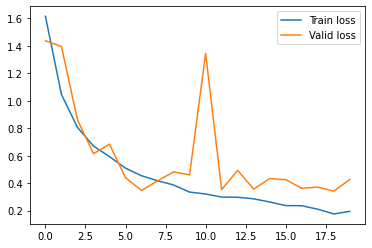

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

#### With Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

resnet18_with_aug = ResNet18(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet18_with_aug.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(resnet18_with_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images
Training epoch 1 | Loss 1.717659 | Accuracy 45.18% | F1 39.83% | Precision 45.68% | Recall 45.18% | Time 79.90 seconds
Validation epoch 1 | Loss 1.690960 | Accuracy 45.47% | F1 38.28% | Precision 43.12% | Recall 45.47% | Time 13.09 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.208445 | Accuracy 61.58% | F1 58.88% | Precision 60.29% | Recall 61.58% | Time 80.34 seconds
Validation epoch 2 | Loss 1.302511 | Accuracy 56.63% | F1 51.40% | Precision 60.35% | Recall 56.63% | Time 12.75 seconds
Training epoch 3 | Loss 0.996284 | Accuracy 68.24% | F1 66.53% | Precision 67.10% | Recall 68.24% | Time 79.66 seconds
Validation epoch 3 | Loss 0.979755 | Accuracy 69.68% | F1 68.07% | Precision 71.89% | Recall 69.68% | Time 13.01 seconds
Training epoch 4 | Loss 0.846313 | Accuracy 72.71% | F1 71.40% | Precision 71.91% | Recall 72.71% | Time 79.61 seconds
Validation epoch 4 | Loss 1.001308 | Accuracy 68.53% | F1 67.36% | Precision 74.60% | Recall 68.53% | Time 13.51 seconds
Training epoch 5 | Loss 0.750430 | Accuracy 75.03% | F1 74.11% | Precision 74.23% | Recall 75.03% | Time 80.62 seconds
Validation epoch 5 | Loss 0.616258 | Accuracy 80.84% | F1 80.46% | Precision 80.88% | Recall 80.84% | Time 13.10 seconds
Training epoch 6 | Loss 0.676646 | Accur

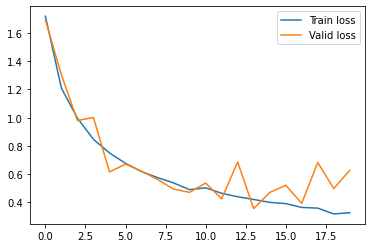

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

## 3) Pre-Trained ResNet50 (torch vision)

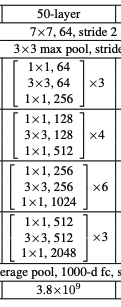

I will use Pretrained [PyTorch ResNet](https://pytorch.org/hub/pytorch_vision_resnet/) implementation. I think trying with transfer learning is a good option for this problem. This model comes with pretrained weights out of the box (trained with imagenet) that could save time of training and produce very good results.

In [ ]:
class TorchVisionResNet50(nn.Module):
  def __init__(self):
    super(TorchVisionResNet50, self).__init__()
    self.net = models.resnet50(pretrained=True)
    num_features = self.net.fc.in_features
    self.net.fc = nn.Linear(num_features, len(TARGET_CLASSES))
  
  def forward(self, x):
    return self.net(x)

#### Without Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

resnet50 = TorchVisionResNet50().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet50.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(resnet50, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Training epoch 1 | Loss 0.632308 | Accuracy 81.53% | F1 81.06% | Precision 81.64% | Recall 81.53% | Time 57.30 seconds
Validation epoch 1 | Loss 0.176996 | Accuracy 94.42% | F1 94.43% | Precision 94.53% | Recall 94.42% | Time 12.23 seconds
Training epoch 2 | Loss 0.180023 | Accuracy 94.53% | F1 94.49% | Precision 94.51% | Recall 94.53% | Time 57.64 seconds
Validation epoch 2 | Loss 0.151128 | Accuracy 95.37% | F1 95.19% | Precision 95.30% | Recall 95.37% | Time 11.99 seconds
Training epoch 3 | Loss 0.098429 | Accuracy 96.89% | F1 96.89% | Precision 96.89% | Recall 96.89% | Time 57.23 seconds
Validation epoch 3 | Loss 0.197559 | Accuracy 93.89% | F1 94.03% | Precision 94.77% | Recall 93.89% | Time 12.09 seconds
Training epoch 4 | Loss 0.053322 | Accuracy 98.55% | F1 98.56% | Precision 98.56% | Recall 98.55% | Time 57.13 seconds
Validation epoch 4 | Loss 0.146040 | Accuracy 95.79% | F1 95.81% | Precision 95.89% | Recall 95.79% | Time 12.54 seconds
Training epoch 5 | Loss 0.032159 | Accu

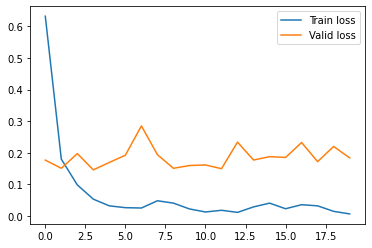

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

#### With Image Augmentation

In [ ]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 20

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

resnet50_with_aug = TorchVisionResNet50().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet50_with_aug.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(resnet50_with_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

3800 Training images, 950 Validation images
Training epoch 1 | Loss 0.742246 | Accuracy 77.87% | F1 77.21% | Precision 78.09% | Recall 77.87% | Time 57.31 seconds
Validation epoch 1 | Loss 0.314943 | Accuracy 88.84% | F1 89.02% | Precision 89.90% | Recall 88.84% | Time 12.69 seconds
Training epoch 2 | Loss 0.304892 | Accuracy 90.68% | F1 90.57% | Precision 90.58% | Recall 90.68% | Time 58.44 seconds
Validation epoch 2 | Loss 0.258848 | Accuracy 92.11% | F1 92.06% | Precision 92.76% | Recall 92.11% | Time 12.12 seconds
Training epoch 3 | Loss 0.206421 | Accuracy 93.18% | F1 93.13% | Precision 93.14% | Recall 93.18% | Time 57.13 seconds
Validation epoch 3 | Loss 0.195950 | Accuracy 93.58% | F1 93.58% | Precision 93.67% | Recall 93.58% | Time 12.11 seconds
Training epoch 4 | Loss 0.166903 | Accuracy 94.82% | F1 94.79% | Precision 94.80% | Recall 94.82% | Time 57.14 seconds
Validation epoch 4 | Loss 0.177141 | Accuracy 93.79% | F1 93.94% | Precision 94.44% | Recall 93.79% | Time 12.20 seco

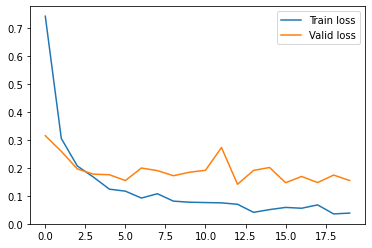

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

# Test prediction & download csv file

In [ ]:
model_to_test = resnet50_with_aug

In [ ]:
### Test set predictions

# Load test folder
test_path = "/content/drive/My Drive/Tryolabs-CV-Interview/data/test/"
test_files = [test_path + filename for filename in os.listdir(test_path)]

test_predictions =[]

# set model to evaluation state
model_to_test.eval()

with torch.no_grad(): # no gradients calculation for the operations inside this block
  for path in test_files: # transform each test image and predict
      img = Image.open(path).convert("RGB")

      img = transforms.functional.resize(img, (256, 256))
      img = transforms.functional.to_tensor(img)
      
      input = Variable(img.type(torch.cuda.FloatTensor)).to(device)
      input = input.unsqueeze(0) # no batch -> [3, 256, 256] instead of [32, 3, 256, 256]

      predictions = model_to_test(input) 
      
      preds = torch.argmax(predictions, dim=1).cpu()
      test_predictions.append(preds)

test_predictions = np.array(test_predictions)

# Generate and download csv with test predictions
csv_results = pd.DataFrame([TARGET_CLASSES[pred] for pred in test_predictions], os.listdir(test_path))[0]
csv_results = csv_results.reset_index(level = 0)
csv_results.columns = ["file", "species"]
csv_results.to_csv("seeds_predictions.csv", header = True, index = False)
files.download('seeds_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results & conclusions

In the following section I will present results for the three models, selecting one as the chosen one and justifying the selection. In addition, I will share how was the training phase and which hyperparams variations I did to improve results.

## Models comparative table

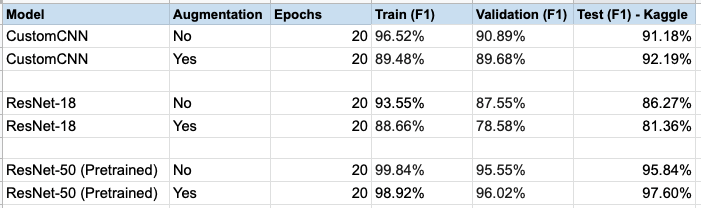

As we can see, all the models performs very well in Kaggle. Another thing to take into consideration, is that in most of the cases Image Augmentation strategy helps the model to perform even better.

For the case of ResNet-18, I followed all the alignments presented in the paper. But for the case of CustomCNN, while analyzing results, I decided to add certain components to the arch in order to avoid overfitting. After every convolution I added a `BatchNorm2D` to normalize tensors values. For the activation function I decided to use Relu since is the one that generally gives better results and this was the case. As another regularization technique, before every linear layer I added a dropout component to turn on/off random neurons.

CustomCNN with Image Augmentation shows better performance than without. In addition, train & valid F1 score is almost the same which gives the sense of good generalization. CustomCNN without IA train F1 score is 6% above validation, even though is not a big difference is more close to overfitting. Regarding test results we can see how IA makes a positive difference between both models.

As I decided to train all the models with 20 epochs, CustomCNN performed better than ResNet-18, but looking at the plots seems that ResNet-18 could be improved with some more epochs. I preferred to set epochs number the same for all the models in order to compare them under same conditions.

Something interesting is that ResNet-18 performed better without Image Augmentation. Not always IA should improve results, perhaps another combination of transforms would make ResNet-18 with IA better than without. But again, I wanted to compare all the models under same conditions. 

Lastly, the model with better results is ResNet-50 pretrained. For this one Image Augmentation was a very helpful technique to improve results, having 2% of improvement in test score.


### Final selection

I will choose ***Pretrained ResNet-50 with IA*** as the best model. Test result confirms the power of generalization of the model, been capable to correctly predict the class for images never seen before.

## Training

For training I always used a set of train and validation images, this allowed me to have insights about overfitting during training (train and validation score for each epoch).

I considered that CrossEntropy was the more adequate for this classification problem. Regarding optimizators, I tried with SGD & Adam, been Adam the one with better results and so the selected for all the experiments. Learning rate used along the models is set to 0.0001, this number was the one with better results compared to other values such as 0.001 and 0.00005.

When implementing the models, it was very helpful to plot loss evolution along the epochs to obtain indicators of model performance and generalization (this was helpful for hyperparam optimization).

For all the experiments I decided to set epochs to 20, at the beginning I used 10 but all the models had room for more training epochs. I also tested using 30 epochs but most of the models showed overfitting (loss evolution plot) having worst results in test set.

## Next Steps

If this project continues in the future, I would experiment some other things such as:

*   Early Stopping as another regularization technique to stop training when the loss during epochs is not decreasing (run out of patience).
*   Segmentation to detect plant and classify with black background.
*   More pre-processing of the images using OpenCV for example.

Nicolás Eiris 